# Task

#### Build a Convolutional Neural Network (CNN) model to classify images from a given dataset into predefined categories/classes.

## The Dataset

#### We could choose between Animals 10 and CIFAR-10; we chose the latter to focus on training our models.

#### - 60,000 32x32 color images in 10 classes
#### - 6,000 images per class.

## Imports

In [8]:
import os
import pickle
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation, RandomFlip, RandomTranslation, Lambda

## Setting the random seed

#### This will guarantee near-reproducible results.

#### TensorFlow is not bit-exact deterministic by default, so some tiny numerical differences can occur (~0.1 %-0.3 %). 

#### This can escalate exponentially, but the cost for determinism would be slowing down our training using the following import:

#### `from tensorflow.config.experimental import enable_op_determinism`

#### We decided not to use the import.

In [15]:
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Load CIFAR-10 dataset

In [16]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## Data Exploration

#### Let's take a look at the shapes of our training and testing data. 

#### The second, third, and fourth columns of X will be our input format for the NN.

In [17]:
print('X_train: ' ,X_train.shape)
print('X_test: ' ,X_test.shape)
print('y_train: ' ,y_train.shape)
print('y_test: ' ,y_test.shape)

X_train:  (50000, 32, 32, 3)
X_test:  (10000, 32, 32, 3)
y_train:  (50000, 1)
y_test:  (10000, 1)


#### Also, it is good to define our classes as they are presented on the dataset homepage.

#### As we can see below, they are all perfectly balanced.

In [18]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [19]:
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(class_names[u], c)

airplane 5000
automobile 5000
bird 5000
cat 5000
deer 5000
dog 5000
frog 5000
horse 5000
ship 5000
truck 5000


### Check the min max pixel value

#### Just as a sanity check, let's see the min and max of the values, they should be 0 and 255

In [20]:
print("Min pixel value:", X_train.min())
print("Max pixel value:", X_train.max())

Min pixel value: 0
Max pixel value: 255


## Data Preprocessing 

#### Let's make our target y categorical and normalize our X by dividing its value by 255.

### OHE y to categorical 

In [21]:
num_classes = 10
y_train_ohe = to_categorical(y_train, num_classes)
y_test_ohe  = to_categorical(y_test,  num_classes)

In [22]:
print('y_train_ohe: ' ,y_train_ohe.shape)
print('y_test_ohe: ' ,y_test_ohe.shape)

y_train_ohe:  (50000, 10)
y_test_ohe:  (10000, 10)


### Normalize the training and test

In [23]:
X_train = X_train.astype('float32')/255.0

In [24]:
X_test = X_test.astype('float32')/255.0

#### As a sanity check let's see the mean and standard deviation.

In [25]:
mean_train = X_train.mean(axis=(0,1,2))
std_train  = X_train.std(axis=(0,1,2))

mean_test = X_test.mean(axis=(0,1,2))
std_test  = X_test.std(axis=(0,1,2))


print("Mean:", mean_train)
print("Std:", std_train)
print("Mean:", mean_test)
print("Std:", std_test)

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]
Mean: [0.49421427 0.4851322  0.45040992]
Std: [0.24665268 0.24289216 0.2615922 ]


## Challenger Model 6: 

#### Made the first Conv. block to have 64 N and the second 128.

#### Increased the batch size to 512.

#### We got 77 % as Test accuracy and 0.65 as test loss.

In [149]:
challenger6 = Sequential([
    Conv2D(64, (3,3), activation="relu", input_shape=(32,32,3)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), padding="same", activation="relu"),
    Conv2D(128, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

challenger6.compile(
    optimizer=SGD(learning_rate=0.05
                  ,momentum=0.9
                  ,nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=3, name="top3_accuracy")]
)

In [26]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [150]:
challenger6_history = challenger6.fit(
    X_train, y_train_ohe,
    validation_split=0.1,
    epochs=50,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 92s 989ms/step - accuracy: 0.1248 - loss: 2.2845 - top3_accuracy: 0.3549 - val_accuracy: 0.0980 - val_loss: 2.2961 - val_top3_accuracy: 0.3210
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 941ms/step - accuracy: 0.1241 - loss: 2.2758 - top3_accuracy: 0.3577 - val_accuracy: 0.1742 - val_loss: 2.2297 - val_top3_accuracy: 0.4592
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 932ms/step - accuracy: 0.1675 - loss: 2.1936 - top3_accuracy: 0.4597 - val_accuracy: 0.2204 - val_loss: 2.0540 - val_top3_accuracy: 0.5534
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 85s 963ms/step - accuracy: 0.2101 - loss: 2.0807 - top3_accuracy: 0.5344 - val_accuracy: 0.2358 - val_loss: 2.0037 - val_top3_accuracy: 0.5946
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 945ms/step - accuracy: 0.2253 - loss: 2.0176 - top3_accuracy: 0.5713 - val_accuracy: 0.2736 - val_loss: 1.8899 - val_top3_accuracy: 0.6502
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 954ms/step - accuracy: 0.2593 - loss: 1.9218 - top3_a

In [151]:
challenger6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 555,926 (2.12 MB)

 Trainable params: 277,962 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 277,964 (1.06 MB)

#### We got 77 % as Test accuracy and 0.65 as test loss.

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.7790 - loss: 0.6412 - top3_accuracy: 0.9524
Test accuracy: 0.7759000062942505
Test loss: 0.6567584872245789


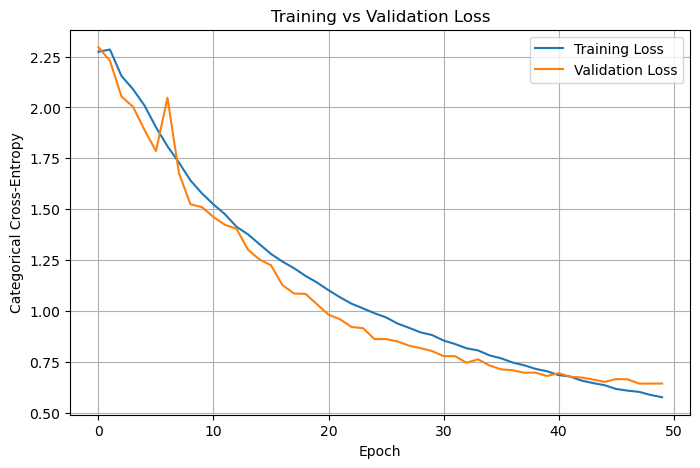

In [152]:
test_loss, test_acc, top3_accuracy = challenger6.evaluate(X_test, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)
print("Test Top3 accuracy:", top3_accuracy)

plt.figure(figsize=(8, 5))
plt.plot(challenger6_history.history['loss'], label='Training Loss')
plt.plot(challenger6_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [156]:
print("Test Top3 accuracy:", top3_accuracy)

Test Top3 accuracy: 0.9502000212669373


In [153]:
y_pred_proba = challenger6.predict(X_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step


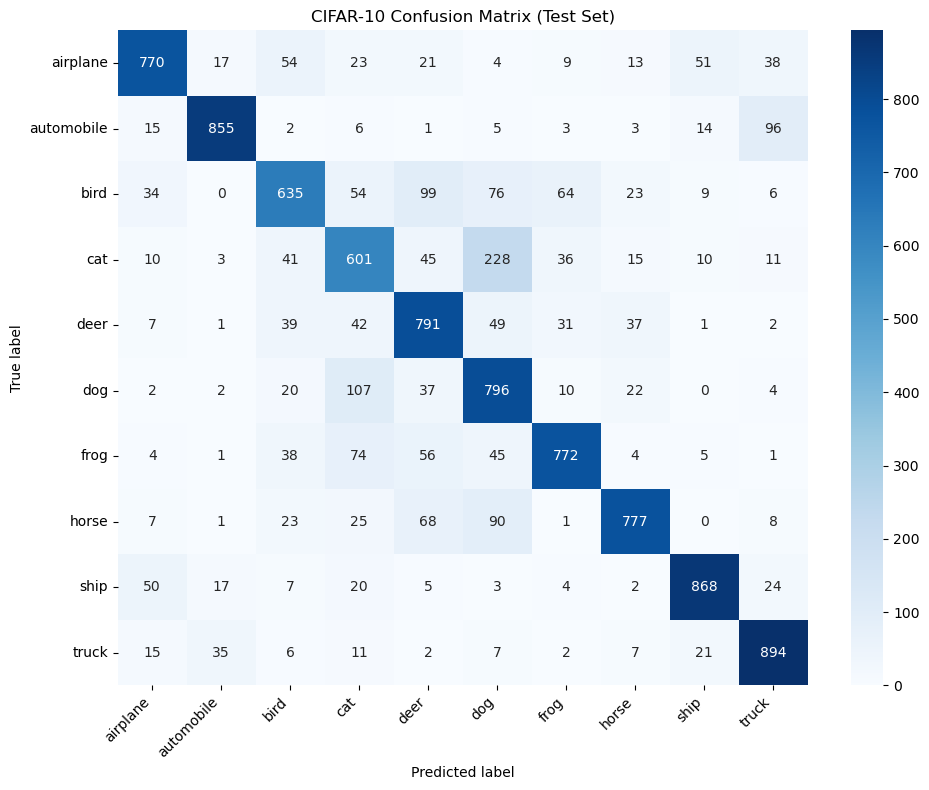

In [154]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [157]:
with open('challenger6.pkl', 'wb') as file:
    pickle.dump(challenger6, file)

In [29]:
m.compile(
    optimizer=SGD(learning_rate=0.05, momentum=0.9, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=3, name="top3_accuracy")]
)

In [30]:
m.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (1, 32, 32, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_1                 │ (1, 32, 32, 3)              │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (1, 32, 32, 64)             │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (1, 32, 32, 64)             │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 16, 16, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 16, 16, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (1, 16, 16, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (1, 16, 16, 128)            │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (1, 8, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (1, 8, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (1, 128)                    │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 128)                    │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 10)                     │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,962 (1.06 MB)

 Trainable params: 277,962 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
test_loss, test_acc, top3_accuracy = m.evaluate(X_test, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)
print("Test Top3 accuracy:", top3_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.8426 - loss: 0.4780 - top3_accuracy: 0.9696
Test accuracy: 0.8431000113487244
Test loss: 0.4781797230243683
Test Top3 accuracy: 0.9702000021934509


In [44]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train_ohe = to_categorical(y_train, 10)
y_test_ohe  = to_categorical(y_test, 10)

X_train_pp = preprocess_input(X_train.astype("float32"))
X_test_pp  = preprocess_input(X_test.astype("float32"))

In [63]:
vgg_transfer = VGG19(
    include_top=False,
    weights="imagenet",      
    input_shape=(32, 32, 3)
)

vgg_transfer.trainable = False

In [64]:
vgg_model = Sequential([ 
    RandomFlip("horizontal"),
    RandomTranslation(0.1, 0.1),
    
    Lambda(preprocess_input, name="vgg19_preprocess"),

    vgg_transfer,

    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(10, activation="softmax")    
])

vgg_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

vgg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ ?                           │     0 (unbuilt) │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19_preprocess (Lambda)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [67]:
vgg_transfer.trainable = True   # Unfreezes

for layer in vgg_model.layers[:-4]:
    layer.trainable = False

vgg_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [101]:
p = Path("vgg_model.pkl")
data = p.read_bytes()


idx = data.find(b"PK\x03\x04")
print("ZIP header index:", idx)

if idx != -1:
    out = Path("recovered_model.keras")
    out.write_bytes(data[idx:])
    print("Wrote:", out, "size MB:", out.stat().st_size / (1024*1024))

    # Verify zip integrity
    with zipfile.ZipFile(out, "r") as z:
        print("Zip OK. First entries:", z.namelist()[:20])
else:
    print("No embedded zip header found inside the pickle.")

Files in archive (first 30): ['metadata.json', 'config.json', 'model.weights.h5']
Weight candidates: ['model.weights.h5']
Extracted weights file: model.weights.h5


In [ ]:
keras_zip = "recovered_model.keras"

with zipfile.ZipFile(keras_zip, "r") as z:
    names = z.namelist()
    print("Files in archive (first 30):", names[:30])

    weight_candidates = [n for n in names if n.endswith(".weights.h5") or "weights" in n.lower() and n.endswith(".h5")]
    print("Weight candidates:", weight_candidates)

    weights_name = weight_candidates[0]
    z.extract(weights_name, ".")

print("Extracted weights file:", weights_name)

In [102]:
vgg_transfer = VGG19(include_top=False
                     ,weights=None
                     ,input_shape=(32, 32, 3)
                    )

vgg_fixed = Sequential([
    RandomFlip("horizontal"),
    RandomTranslation(0.1, 0.1),

    # Lambda removed
    vgg_transfer,

    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(10, activation="softmax")
])

In [103]:
dummy = tf.zeros((1, 32, 32, 3), dtype=tf.float32)
_ = vgg_fixed(dummy, training=False)

vgg_fixed.load_weights(weights_name)

In [106]:
vgg_fixed.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [107]:
vgg_fixed.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (1, 32, 32, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (1, 32, 32, 3)              │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (1, 1, 1, 512)              │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (1, 512)                    │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 512)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 10)                     │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,029,514 (76.41 MB)

 Trainable params: 20,029,514 (76.41 MB)

 Non-trainable params: 0 (0.00 B)

##### We go test accuracy of 82 %, val loss 0.58.

In [109]:
x = preprocess_input(X_test.astype("float32"))

test_loss, test_acc = vgg_fixed.evaluate(x, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 176ms/step - accuracy: 0.8315 - loss: 0.5661
Test accuracy: 0.8271999955177307
Test loss: 0.585747480392456


##### We could hyperparametrize more but we are good